In [37]:
import pandas as pd
import numpy as np
import calendar
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import optuna
import torch
from optuna.trial import TrialState
from torch.utils.data import Dataset, DataLoader, TensorDataset,Subset
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from sklearn.linear_model import LinearRegression
import seaborn as sns
plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)
import sys
sys.path.append('../..') # add parent path to sys.path
from HydroPy.Preprocessing.OneShotSamplesGenerator import gen_one_out_samples
from HydroPy.DataTools.Dataset import SimulatedSequenceDataset

from HydroPy.NeuralNetwork.LSTMRegressor import LSTMRegressor,save_model,load_model
from HydroPy.NeuralNetwork.LSTMRegressor import DEVICE
from HydroPy.NeuralNetwork.LSTMRegressor import train_model
from HydroPy.NeuralNetwork.LSTMRegressor import test_model
from HydroPy.NeuralNetwork.LSTMRegressor import predict
from HydroPy.NeuralNetwork.LSTMRegressor import plot_train_val_loss_cv
from HydroPy.NeuralNetwork.LSTMRegressor import save_best_trial
from HydroPy.NeuralNetwork.LSTMRegressor import load_best_trial
from HydroPy.NeuralNetwork.LSTMRegressor import Objective_CV,Objective
from HydroPy.Evaluation.metrics import NSE,NNSE,RMSE,NRMSE,ZNRMSE,MAE,PPTS,LPTS,MAPE,R2

In [38]:
station = 'xunhua'
df = pd.read_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/full_modeling_data_{}.csv'.format(station),parse_dates=['date'],index_col='date')
target = 'flow'
features = list(df.columns.difference([target]))
features = list(df.columns.copy())
features.remove(target)
print(features)

mlr_prediction = df.copy()
mlr_y = mlr_prediction.loc['1957-01-01':'1981-12-31',target]
mlr_X = mlr_prediction.loc['1957-01-01':'1981-12-31',features]

mlr_model = LinearRegression().fit(mlr_X,mlr_y)
for val in list(mlr_model.coef_):
    print("{0:.2f}".format(val))
print("截距: ", mlr_model.intercept_)
print("系数: ", mlr_model.coef_)

mlr_prediction['VIF_MLR'] = mlr_model.predict(mlr_prediction.loc['1957-01-01':'2018-12-31',features])
mlr_prediction = mlr_prediction.loc[:,['flow','VIF_MLR']]
# print(mlr_prediction)
mlr_prediction.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/naturalization_1957_2018_vifmlr_{}.csv'.format(station))

mlr_cal = mlr_prediction.loc['1957-01-01':'1981-12-31',:]
mlr_test = mlr_prediction.loc['1982-01-01':'1985-12-31',:]
mlr_cal_nse = round(NSE(mlr_cal['flow'],mlr_cal['VIF_MLR']),4)
mlr_cal_nnse = round(NNSE(mlr_cal['flow'],mlr_cal['VIF_MLR']),4)
mlr_cal_rmse = round(RMSE(mlr_cal['flow'],mlr_cal['VIF_MLR']),4)
mlr_cal_nrmse = round(NRMSE(mlr_cal['flow'],mlr_cal['VIF_MLR']),4)
mlr_cal_znrmse = round(ZNRMSE(mlr_cal['flow'],mlr_cal['VIF_MLR']),4)
mlr_cal_mae = round(MAE(mlr_cal['flow'],mlr_cal['VIF_MLR']),4)
mlr_cal_mape = round(MAPE(mlr_cal['flow'],mlr_cal['VIF_MLR']),4)
mlr_cal_ppts = round(PPTS(mlr_cal['flow'],mlr_cal['VIF_MLR'],5),4)
mlr_cal_lpts = round(LPTS(mlr_cal['flow'],mlr_cal['VIF_MLR'],5),4)

mlr_test_nse = round(NSE(mlr_test['flow'],mlr_test['VIF_MLR']),4)
mlr_test_nnse = round(NNSE(mlr_test['flow'],mlr_test['VIF_MLR']),4)
mlr_test_rmse = round(RMSE(mlr_test['flow'],mlr_test['VIF_MLR']),4)
mlr_test_nrmse = round(NRMSE(mlr_test['flow'],mlr_test['VIF_MLR']),4)
mlr_test_znrmse = round(ZNRMSE(mlr_test['flow'],mlr_test['VIF_MLR']),4)
mlr_test_mae = round(MAE(mlr_test['flow'],mlr_test['VIF_MLR']),4)
mlr_test_mape = round(MAPE(mlr_test['flow'],mlr_test['VIF_MLR']),4)
mlr_test_ppts = round(PPTS(mlr_test['flow'],mlr_test['VIF_MLR'],5),4)
mlr_test_lpts = round(LPTS(mlr_test['flow'],mlr_test['VIF_MLR'],5),4)

mlr_metrix = pd.DataFrame(index=['cal','test'])
mlr_metrix['NSE'] = [mlr_cal_nse,mlr_test_nse]
mlr_metrix['NNSE'] = [mlr_cal_nnse,mlr_test_nnse]
mlr_metrix['RMSE'] = [mlr_cal_rmse,mlr_test_rmse]
mlr_metrix['NRMSE'] = [mlr_cal_nrmse,mlr_test_nrmse]
mlr_metrix['ZNRMSE'] = [mlr_cal_znrmse,mlr_test_znrmse]
mlr_metrix['MAE'] = [mlr_cal_mae,mlr_test_mae]
mlr_metrix['MAPE'] = [mlr_cal_mape,mlr_test_mape]
mlr_metrix['PPTS'] = [mlr_cal_ppts,mlr_test_ppts]
mlr_metrix['LPTS'] = [mlr_cal_lpts,mlr_test_lpts]
print(mlr_metrix)
mlr_metrix.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/naturalization_1957_1985_vifmlr_metrics_{}.csv'.format(station))


cal = df.loc[:'1982-12-31',:]
test = df.loc['1982-01-01':'1985-12-31',:]
pre = df.loc['1985-01-01':,:]


X_scaler = MinMaxScaler(feature_range=(0,1))
Y_scaler = MinMaxScaler(feature_range=(0,1))
X_scaler.fit(cal[features])
Y_scaler.fit(cal[[target]])

cal_X = X_scaler.transform(cal[features])
test_X = X_scaler.transform(test[features])
pre_X = X_scaler.transform(pre[features])

cal_y = Y_scaler.transform(cal[[target]])
test_y = Y_scaler.transform(test[[target]])
pre_y = Y_scaler.transform(pre[[target]])

cal = pd.concat([pd.DataFrame(cal_X,columns=features,index=cal.index),pd.DataFrame(cal_y,columns=[target],index=cal.index)],axis=1)
test = pd.concat([pd.DataFrame(test_X,columns=features,index=test.index),pd.DataFrame(test_y,columns=[target],index=test.index)],axis=1)
pre = pd.concat([pd.DataFrame(pre_X,columns=features,index=pre.index),pd.DataFrame(pre_y,columns=[target],index=pre.index)],axis=1)

# print(cal)
# print(test)
# print(pre)


['v10', 'sd', 'ssro', 'sro', 'smlt', 'P208_GD', 'P820_GD', 'P820_GH', 'tnh_flow']
-4.51
-363.65
6461.80
-2893.28
553.47
0.13
0.88
0.12
0.98
截距:  30.680925787714614
系数:  [-4.51322312e+00 -3.63649815e+02  6.46179847e+03 -2.89327684e+03
  5.53466158e+02  1.32632850e-01  8.79895912e-01  1.21361040e-01
  9.77767947e-01]
         NSE    NNSE     RMSE   NRMSE  ZNRMSE      MAE    MAPE    PPTS  \
cal   0.9939  0.9939  43.3085  0.0784  0.0121  31.0980  5.4632  3.2901   
test  0.9894  0.9895  68.2170  0.1028  0.0268  54.6603  8.4570  3.0680   

         LPTS  
cal   11.8368  
test  11.8144  


In [39]:
sequence_length =12
cal_dataset = SimulatedSequenceDataset(
    dataframe=cal.copy(),
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SimulatedSequenceDataset(
    dataframe=test.copy(),
    target=target,
    features=features,
    sequence_length=sequence_length
)

pre_dataset = SimulatedSequenceDataset(
    dataframe=pre.copy(),
    target=target,
    features=features,
    sequence_length=sequence_length
)
full_dataset = SimulatedSequenceDataset(
    dataframe=df.copy(),
    target=target,
    features=features,
    sequence_length=sequence_length
)

# print(test_dataset.__len__())
i=0
X, y = cal_dataset[i]
print(X)
print(y)
# print(cal_dataset.X)
# print(cal_dataset.y)

print(cal_dataset.X.shape, cal_dataset.y.shape)
print(test_dataset.X.shape, test_dataset.y.shape)
print(pre_dataset.X.shape, pre_dataset.y.shape)

cal_index = cal.index[sequence_length:]
test_index = test.index[sequence_length:]
pre_index = pre.index[sequence_length:]
full_index = df.index[sequence_length:]

print(cal_index)
# print(test_index)
# print(pre_index)
print(len(cal_index)==cal_dataset.__len__())
print(len(test_index)==test_dataset.__len__())
print(len(pre_index)==pre_dataset.__len__())
print(len(full_index)==full_dataset.__len__())

tensor([[1.0000e+00, 2.6781e-01, 1.7827e-01, 7.4887e-03, 2.3818e-02, 2.1321e-02,
         4.2562e-02, 1.2370e-02, 2.2993e-02],
        [5.5488e-01, 3.2699e-01, 1.1966e-01, 1.6993e-02, 2.8602e-02, 1.3981e-03,
         6.2591e-04, 1.8192e-04, 2.0145e-02],
        [6.8174e-01, 3.9779e-01, 7.7930e-02, 5.2038e-02, 1.4632e-01, 3.2623e-02,
         0.0000e+00, 1.8192e-04, 3.2676e-02],
        [6.1101e-01, 3.4475e-01, 5.1659e-02, 2.3406e-01, 4.2044e-01, 2.3220e-01,
         1.9278e-01, 3.9658e-02, 7.2575e-02],
        [3.2674e-01, 2.8993e-01, 4.4660e-02, 3.4431e-01, 7.6972e-01, 7.0139e-02,
         2.4507e-01, 1.7810e-01, 1.1591e-01],
        [8.3774e-02, 7.4556e-02, 6.9488e-02, 4.1679e-01, 6.4460e-01, 8.0741e-02,
         7.8865e-02, 2.4359e-01, 1.5095e-01],
        [9.8413e-02, 9.1423e-03, 3.0060e-01, 3.7066e-01, 2.3808e-01, 8.2640e-01,
         3.6658e-01, 1.0000e+00, 2.8179e-01],
        [2.9870e-01, 5.6184e-03, 7.1111e-01, 1.9813e-01, 1.7277e-01, 1.1674e-01,
         2.8020e-01, 2.0375e-0

Split calibration dataset into 4 groups: spring March, April, and May; summer as June, July, and August; autumn as September, October, and November; and winter as December, January, and February.

In [40]:

class FliterMonthDataset(Dataset):
    def __init__(self, dataset:torch.utils.data.Dataset, index:pd.DatetimeIndex, months:list):
        self.dataset = dataset
        idx_list = []
        for idx,i_ in zip(index,range(self.dataset.y.shape[0])):
            if idx.month in months:
                idx_list.append(i_)
        
        self.subdataset = Subset(self.dataset, idx_list)
  
    def __len__(self):
        return len(self.subdataset)
    
    def __getitem__(self, i):
        X,y = self.subdataset[i]
        return X,y
    
    
spring_dataset = FliterMonthDataset(dataset=cal_dataset, index=cal_index, months=[3,4,5])
summer_dataset = FliterMonthDataset(dataset=cal_dataset, index=cal_index, months=[6, 7, 8])
autumn_dataset = FliterMonthDataset(dataset=cal_dataset, index=cal_index, months=[9, 10, 11])
winter_dataset = FliterMonthDataset(dataset=cal_dataset, index=cal_index, months=[12, 1, 2])
spring_dataset


In [41]:
RETRAIN = False

In [42]:
model_path = 'D:/ResearchSpace/NaturalStreamflowReconstructionFramework/model/naturailization/{}/LSTM_lag12/test/'.format(station)
if RETRAIN:
    objective = Objective(
            train_dataset=cal_dataset,
            val_dataset=test_dataset,
            num_epoch=1000,
            batch_size=32,
            shuffle=True,
            model_path='./scheme/LSTMRegressor/',
    )
    study = optuna.create_study(
            study_name='example-study',
            direction='minimize',
        )
    study.optimize(objective, n_trials=100)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])


    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    save_best_trial(trial, model_path=model_path)

    save_model(trial, model_path=model_path)

    best_model_state = trial.user_attrs["best_model_state"]
    

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



C:\Users\ZJY\AppData\Local\Temp\ipykernel_85312\2555885856.py:92: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\ZJY\AppData\Local\Temp\ipykernel_85312\2555885856.py:94: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\ZJY\AppData\Local\Temp\ipykernel_85312\2555885856.py:122: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ZJY\AppData\Local\Temp\ipykernel_85312\2555885856.py:152: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 0.40925157  1.12661667  3.67864835  0.30427827  1.37136384  2.33976976
  1.35101637  0.96388005 45.80516825]


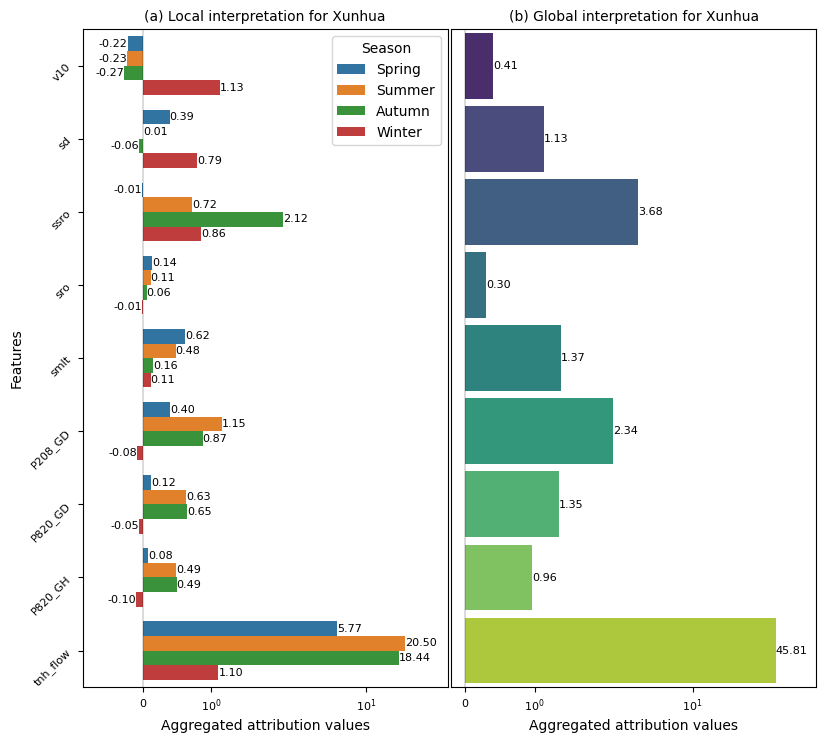

{'num_layers': 1,
 'hidden_size': 40,
 'lstm_dropout': 0.19265508955182398,
 'dense_dropout': 0.002846856114430224,
 'learning_rate': 0.08468931536255477}

In [43]:
best_trial = load_best_trial(model_file=model_path+'best_trial.pickle')
model1 = load_model(model_file=model_path+'model.pickle').to(DEVICE)

ig = IntegratedGradients(model1)

# features_ = []
# for name in features:
#     if '_' in name:
#         name = name.split('_')[0]+'_{'+name.split('_')[1]+'}'
#     features_.append('$'+name+'$')

spring_loader = DataLoader(spring_dataset,batch_size=spring_dataset.__len__(),shuffle=False)
summer_loader = DataLoader(summer_dataset,batch_size=summer_dataset.__len__(),shuffle=False)
autumn_loader = DataLoader(autumn_dataset,batch_size=autumn_dataset.__len__(),shuffle=False)
winter_loader = DataLoader(winter_dataset,batch_size=winter_dataset.__len__(),shuffle=False)

aggregated_attributions_spring = []
aggregated_attributions_summer = []
aggregated_attributions_autumn = []
aggregated_attributions_winter = []

# Iterate over the test dataloader batches
for inputs, labels in spring_loader:
    # Generate attributions using Integrated Gradients
    attributions_spring = ig.attribute(inputs.to(DEVICE))
    aggregated_attributions_spring.append(attributions_spring.cpu())
for inputs, labels in summer_loader:
    # Generate attributions using Integrated Gradients
    attributions_summer = ig.attribute(inputs.to(DEVICE))
    aggregated_attributions_summer.append(attributions_summer.cpu())
for inputs, labels in autumn_loader:
    # Generate attributions using Integrated Gradients
    attributions_autumn = ig.attribute(inputs.to(DEVICE))
    aggregated_attributions_autumn.append(attributions_autumn.cpu())
for inputs, labels in winter_loader:
    # Generate attributions using Integrated Gradients
    attributions_winter = ig.attribute(inputs.to(DEVICE))
    aggregated_attributions_winter.append(attributions_winter.cpu())

attributions_spring_sum = attributions_spring.sum(dim=0) # (13,8)
attributions_spring_sum = np.array(attributions_spring_sum.sum(dim=0).cpu()) # (8)

attributions_summer_sum = attributions_summer.sum(dim=0)
attributions_summer_sum = np.array(attributions_summer_sum.sum(dim=0).cpu())

attributions_autumn_sum = attributions_autumn.sum(dim=0)
attributions_autumn_sum = np.array(attributions_autumn_sum.sum(dim=0).cpu())

attributions_winter_sum = attributions_winter.sum(dim=0)
attributions_winter_sum = np.array(attributions_winter_sum.sum(dim=0).cpu())

df = pd.DataFrame({
    'Spring':attributions_spring_sum,
    'Summer':attributions_summer_sum,
    'Autumn':attributions_autumn_sum,
    'Winter':attributions_winter_sum,
},index=features)

df = df.reset_index().melt(id_vars='index', var_name='Season', value_name='Contribution')

# 使用seaborn的barplot函数绘制柱状图
ftsize=10
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(7.48, 7))
ax1 = sns.barplot(x='Contribution', y='index', hue='Season', data=df, orient='h',ax=ax1)
# 在柱状图的柱子上显示数值
# 在柱状图的柱子上显示数值和短线
for p in ax1.patches:
    width = p.get_width()    # 获取柱子的宽度
    if abs(width) < 0.001:  # 如果值接近0，跳过
        continue
    if abs(width) < 0.1:  # 如果值接近0，设置一个较小的偏移量
        offset = 0.02
    else:  # 如果值较大，设置一个较大的偏移量
        offset = 0.2
    if width >=0:    # 如果宽度为正（即值为正）
        ax1.text(width ,       # 在柱子右边端点以外
                p.get_y() + p.get_height() / 2,  # y坐标（柱子的中心）
                '{:1.2f}'.format(width),   # 要显示的文本（柱子的宽度，保留两位小数）
                ha = 'left',   # 水平对齐方式
                va = 'center',
                fontsize=8)  # 垂直对齐方式
    else:    # 如果宽度为负（即值为负）
        ax1.text(width ,       # 在柱子左边端点以外
                p.get_y() + p.get_height() / 2,  # y坐标（柱子的中心）
                '{:1.2f}'.format(width),   # 要显示的文本（柱子的宽度，保留两位小数）
                ha = 'right',   # 水平对齐方式
                va = 'center',
                fontsize=8)  # 垂直对齐方式
ax1.set_xlim(df['Contribution'].min()-0.6, df['Contribution'].max()+25)
ax1.axvline(x=0.0, color='black', linestyle='-', linewidth=0.2)
ax1.set_ylabel('Features',fontsize=ftsize)
ax1.set_yticklabels(features,fontsize=8,rotation=45)
ax1.set_xlabel('Aggregated attribution values',fontsize=ftsize)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=8)
ax1.set_xscale('symlog')
ax1.set_title('(a) Local interpretation for {}'.format(station.capitalize()),fontsize=ftsize)

cal_dataloader = DataLoader(cal_dataset)
aggregated_attributions = []
# Iterate over the test dataloader batches
for inputs, labels in cal_dataloader:
    # Generate attributions using Integrated Gradients
    attributions = ig.attribute(inputs.to(DEVICE))
    aggregated_attributions.append(attributions.cpu())
# Concatenate the attributions along the batch dimension
aggregated_attributions = torch.cat(aggregated_attributions, dim=0)

# Convert the aggregated_attributions tensor to a numpy array
attributions_np = aggregated_attributions.detach().numpy()

# Calculate the mean attributions across all samples
sum_attributions = np.sum(attributions_np, axis=0)
sum_attributions = np.sum(sum_attributions, axis=0)
print(sum_attributions)

df = pd.DataFrame({
    'Features': features,
    'Attribution Values': sum_attributions
})
# Plot the attributions for each feature
x_pos = (np.arange(len(features)))
ax2 = sns.barplot(x='Attribution Values', y='Features', data=df, orient='h', palette='viridis',width=0.9,ax=ax2)
# Add numbers on each bar
for p in ax2.patches:    
    width = p.get_width()    # 获取柱子的宽度
    if abs(width) < 0.001:  # 如果值接近0，跳过
        continue
    if abs(width) < 0.1:  # 如果值接近0，设置一个较小的偏移量
        offset = 0.02
    else:  # 如果值较大，设置一个较大的偏移量
        offset = 0.2
    if width >=0:    # 如果宽度为正（即值为正）
        ax2.text(width ,       # 在柱子右边端点以外
                p.get_y() + p.get_height() / 2,  # y坐标（柱子的中心）
                '{:1.2f}'.format(width),   # 要显示的文本（柱子的宽度，保留两位小数）
                ha = 'left',   # 水平对齐方式
                va = 'center',
                fontsize=8)  # 垂直对齐方式
    else:    # 如果宽度为负（即值为负）
        ax2.text(width ,       # 在柱子左边端点以外
                p.get_y() + p.get_height() / 2,  # y坐标（柱子的中心）
                '{:1.2f}'.format(width),   # 要显示的文本（柱子的宽度，保留两位小数）
                ha = 'right',   # 水平对齐方式
                va = 'center',
                fontsize=8)  # 垂直对齐方式
ax2.set_xlim(df['Attribution Values'].min()-0.5, df['Attribution Values'].max()+50)
ax2.axvline(x=0.0, color='black', linestyle='-', linewidth=0.2)
ax2.set_yticklabels([])
ax2.yaxis.set_ticks([])
ax2.set_ylabel('')
ax2.set_xlabel('Aggregated attribution values',fontsize=ftsize)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=8)
ax2.set_xscale('symlog')
ax2.set_title('(b) Global interpretation for {}'.format(station.capitalize()),fontsize=ftsize)
fig.subplots_adjust(left=0.01, bottom=0.05, right=0.99,top=0.99, hspace=0.05, wspace=0.01)
plt.savefig('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/figs/{}_features_contributions_IG.eps'.format(station),format='EPS',dpi=2000,transparent=False,bbox_inches='tight')
plt.savefig('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/figs/{}_features_contributions_IG.png'.format(station),format='PNG',dpi=600,transparent=False,bbox_inches='tight')
plt.show()

# def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
#     print(title)
#     for i in range(len(feature_names)):
#         print(feature_names[i], ": ", '%.3f'%(importances[i]))
#     x_pos = (np.arange(len(feature_names)))
#     if plot:
#         plt.figure(figsize=(12,6))
#         plt.bar(x_pos, importances, align='center')
#         plt.xticks(x_pos, feature_names, wrap=True)
#         plt.xlabel(axis_title)
#         plt.title(title)



# for X, y in spring_loader:
#     print(X.shape, y.shape)
#     attr, delta = ig.attribute(
#         inputs=X.to(DEVICE),
#         target=(0),
#         n_steps=100,
#         return_convergence_delta=True
#     )
#     # attr = attr.cpu()
#     print('IG Attributions:', attr.shape)
#     print('Convergence Delta:', delta)

# default_cmap = LinearSegmentedColormap.from_list('custom blue',
#                                                  [(0, '#ffffff'),
#                                                   (0.25, '#0000ff'),
#                                                   (1, '#0000ff')], N=256)

# _ = viz.visualize_image_attr(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              method='heat_map',
#                              cmap=default_cmap,
#                              show_colorbar=True,
#                              sign='positive',
#                              title='Integrated Gradients')

best_trial.params

In [44]:
cal_loader = DataLoader(cal_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
pre_loader = DataLoader(pre_dataset, batch_size=64, shuffle=False)
ystar_col = "VIF_LSTM"
# print(cal)
cal_ = cal.loc[cal_index,[target]].copy()
test_ = test.loc[test_index,[target]].copy()
pre_ = pre.loc[pre_index,[target]].copy()

# get shape of cal_loader
# for X, y in cal_loader:
#     print(X.shape, y.shape)

# print(cal_.shape, test_.shape, pre_.shape)

cal_[ystar_col] = predict(cal_loader, model1).cpu().numpy()
test_[ystar_col] = predict(test_loader, model1).cpu().numpy()
pre_[ystar_col] = predict(pre_loader, model1).cpu().numpy()

metrics = pd.DataFrame(index=['cal','test'])
metrics['NSE'] = [round(NSE(cal_[target], cal_[ystar_col]),4), round(NSE(test_[target], test_[ystar_col]),4)]
metrics['NNSE'] = [round(NNSE(cal_[target], cal_[ystar_col]),4), round(NNSE(test_[target], test_[ystar_col]),4)]
metrics['RMSE'] = [round(RMSE(cal_[target], cal_[ystar_col]),4), round(RMSE(test_[target], test_[ystar_col]),4)]
metrics['NRMSE'] = [round(NRMSE(cal_[target], cal_[ystar_col]),4), round(NRMSE(test_[target], test_[ystar_col]),4)]
metrics['ZNRMSE'] = [round(ZNRMSE(cal_[target], cal_[ystar_col]),4), round(ZNRMSE(test_[target], test_[ystar_col]),4)]
metrics['MAE'] = [round(MAE(cal_[target], cal_[ystar_col]),4), round(MAE(test_[target], test_[ystar_col]),4)]
metrics['MAPE'] = [round(MAPE(cal_[target], cal_[ystar_col]),4), round(MAPE(test_[target], test_[ystar_col]),4)]
metrics['PPTS(5)'] = [round(PPTS(cal_[target], cal_[ystar_col], 5),4), round(PPTS(test_[target], test_[ystar_col], 5),4)]
metrics['LPTS(5)'] = [round(LPTS(cal_[target], cal_[ystar_col], 5),4), round(LPTS(test_[target], test_[ystar_col], 5),4)]
metrics['R2'] = [round(R2(cal_[target], cal_[ystar_col]),4), round(R2(test_[target], test_[ystar_col]),4)]





df_out = pd.concat((cal_, test_, pre_))[[target, ystar_col]]
for c in df_out.columns:
    # df_out[c] = df_out[c] * target_std + target_mean
    df_out[c] = Y_scaler.inverse_transform(df_out[[c]])

print(df_out)
df_out.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/naturalization_1957_2018_viflstm_{}.csv'.format(station))

metrics.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/naturalization_1957_1985_viflstm_{}_metrics.csv'.format(station))

metrics

                   flow     VIF_LSTM
date                                
1958-01-31   188.993429   170.499939
1958-02-28   176.008598   142.817932
1958-03-31   221.998208   191.219971
1958-04-30   298.996914   246.703598
1958-05-31   538.007766   463.207092
...                 ...          ...
2018-08-31  1214.903226  1345.087280
2018-09-30  1999.066667  2248.215576
2018-10-31  1327.225806  1469.026245
2018-11-30   735.700000   769.286987
2018-12-31   668.806452   379.003662

[732 rows x 2 columns]


d:\WorkSpace\HydroPy\projects\NaturalStreamflowReconstructionFramework\../..\HydroPy\Evaluation\metrics.py:91: RuntimeWarning:

divide by zero encountered in divide

d:\WorkSpace\HydroPy\projects\NaturalStreamflowReconstructionFramework\../..\HydroPy\Evaluation\metrics.py:170: RuntimeWarning:

divide by zero encountered in divide



,NSE,NNSE,RMSE,NRMSE,ZNRMSE,MAE,MAPE,PPTS(5),LPTS(5),R2
cal,0.9830,0.9833,0.0215,0.1302,0.0211,0.0175,inf,3.9343,inf,0.9967
test,0.9939,0.9939,0.0158,0.0781,0.0217,0.0113,9.5807,2.6851,12.0002,0.9970


In [45]:
fig = px.line(df_out, labels=dict(created_at="Date", value="flow(m^3/s)"))
fig.add_vline(x=pd.DatetimeIndex(['1983-01-01'])[0], line_width=4, line_dash="dash")
fig.add_vline(x=pd.DatetimeIndex(['1986-01-01'])[0], line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.3, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.add_annotation(xref="paper", x=0.55, yref="paper", y=0.8, text="prediction set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [46]:
print(NSE(cal_[target], cal_[ystar_col]))
print(NSE(test_[target], test_[ystar_col]))

0.9830445888208572
0.9939027153575226


In [47]:
for c in pre_.columns:
    pre_[c] = Y_scaler.inverse_transform(pre_[[c]])
pre_[ystar_col]

date
1986-01-31     211.235977
1986-02-28     193.883377
1986-03-31     221.074448
1986-04-30     330.297485
1986-05-31     791.127014
                 ...     
2018-08-31    1345.087280
2018-09-30    2248.215576
2018-10-31    1469.026245
2018-11-30     769.286987
2018-12-31     379.003662
Name: VIF_LSTM, Length: 396, dtype: float32

In [48]:
prediction = pre_[ystar_col].copy()
prediction = prediction.rename('VIF_LSTM')
prediction.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/{}_monthly_naturalized_flow_viflstm.csv'.format(station))
prediction

natural_flow = pd.read_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/{}_monthly_flow.csv'.format(station), index_col='date', parse_dates=['date'])
natural_flow = natural_flow.loc['1957-01-01':'1985-12-31']
natural_flow.columns = ['VIF_LSTM']
natural_naturalized_flow = pd.concat((natural_flow, prediction), axis=0)
natural_naturalized_flow.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/{}_monthly_natural_naturalized_flow.csv'.format(station))

natural_naturalized_flow

,VIF_LSTM
date,
1957-01-01,164.986559
1957-02-01,163.979828
1957-03-01,201.015532
1957-04-01,351.003086
1957-05-01,514.859618
...,...
2018-08-31,1345.087280
2018-09-30,2248.215576
2018-10-31,1469.026245


In [49]:
lstm_prediction = pd.read_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/naturalization_1957_2018_viflstm_{}.csv'.format(station), index_col='date', parse_dates=['date'])
mlr_prediction = pd.read_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/naturalization_1957_2018_vifmlr_{}.csv'.format(station), index_col='date', parse_dates=['date'])

lstm_prediction = lstm_prediction.loc['1986-01-01':'2018-12-31',['VIF_LSTM']]
mlr_prediction = mlr_prediction.loc['1986-01-01':'2018-12-31',['VIF_MLR']]


avg_lstm_prediction = lstm_prediction['VIF_LSTM'].mean()
avg_mlr_prediction = mlr_prediction['VIF_MLR'].mean()

avg = (avg_lstm_prediction+avg_mlr_prediction)/2

low_20_per = lstm_prediction.copy().sort_values(by='VIF_LSTM', ascending=True).iloc[int(len(lstm_prediction)*0.2)].values[0]


date = pd.date_range('1986-01-01','2018-12-31',freq='ME')

lstm_prediction.set_index(date, inplace=True)

mlr_prediction.set_index(date, inplace=True)

lstm_prediction.index.name='date'

mlr_prediction.index.name='date'



lstm_mlr_prediction=[]
for date in lstm_prediction.index:
    if lstm_prediction.loc[date,'VIF_LSTM']>=low_20_per:
        lstm_mlr_prediction.append(lstm_prediction.loc[date,'VIF_LSTM'])
    else:
        lstm_mlr_prediction.append(mlr_prediction.loc[date,'VIF_MLR'])
lstm_mlr_prediction = pd.DataFrame(lstm_mlr_prediction, index=lstm_prediction.index, columns=['VIF_LSTM_MLR'])
lstm_mlr_prediction.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/{}_monthly_naturalized_flow_viflstm_mlr.csv'.format(station))

sum = 0.0
season = []
for year in range(lstm_prediction.index.year.min(),lstm_prediction.index.year.max()+1):
    for month in range(1,13):
        days = calendar.monthrange(year, month)[1]
        # print(year,month,days)
        date = pd.to_datetime(f'{year}-{month}-{days}')
        if month in [12,1,2]:
            season.append(str(year-1)+'-4')
        if month in [3,4,5]:
            season.append(str(year)+'-1')
        if month in [6,7,8]:
            season.append(str(year)+'-2')
        if month in [9,10,11]:
            season.append(str(year)+'-3')

lstm_prediction['season'] = season
mlr_prediction['season'] = season
lstm_mlr_prediction['season'] = season

# print(mlr_prediction)
# calulate average flow based on season

lstm_prediction = lstm_prediction.groupby('season').mean()
mlr_prediction = mlr_prediction.groupby('season').mean()
lstm_mlr_prediction = lstm_mlr_prediction.groupby('season').mean()

lstm_prediction = lstm_prediction[lstm_prediction.index>='1986-1']
lstm_prediction = lstm_prediction[lstm_prediction.index<='2015-4']

mlr_prediction = mlr_prediction[mlr_prediction.index>='1986-1']
mlr_prediction = mlr_prediction[mlr_prediction.index<='2015-4']

lstm_mlr_prediction = lstm_mlr_prediction[lstm_mlr_prediction.index>='1986-1']
lstm_mlr_prediction = lstm_mlr_prediction[lstm_mlr_prediction.index<='2015-4']

mlr_prediction



,VIF_MLR
season,
1986-1,505.178566
1986-2,1275.636603
1986-3,765.343400
1986-4,213.418504
1987-1,381.632709
...,...
2014-4,273.629878
2015-1,338.035452
2015-2,913.374327


In [50]:
seasonal_flow_vifmlr = pd.read_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/{}_seasonal_naturalization_vifmlr.csv'.format(station))
seasonal_flow_vifmlr['YQ'] = seasonal_flow_vifmlr['year'].astype(str) + '-' + seasonal_flow_vifmlr['season'].astype(str)
seasonal_flow_vifmlr.set_index('YQ', inplace=True)
seasonal_flow_obs = seasonal_flow_vifmlr['natural_flow']
seasonal_flow_mlr = seasonal_flow_vifmlr['VIF_MLR']

seasonal_flow = pd.DataFrame(index=seasonal_flow_obs.index)
seasonal_flow['natural_flow'] = seasonal_flow_obs.values
seasonal_flow['VIF_MLR'] = mlr_prediction.values
seasonal_flow['VIF_LSTM'] = lstm_prediction.values
seasonal_flow['VIF_LSTM_MLR'] = lstm_mlr_prediction.values

seasonal_flow.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/{}_seasonal_naturalization.csv'.format(station))
seasonal_flow

,natural_flow,VIF_MLR,VIF_LSTM,VIF_LSTM_MLR
YQ,,,,
1986-1,469,505.178566,447.499650,447.499650
1986-2,1156,1275.636603,1221.509477,1221.509477
1986-3,696,765.343400,709.444217,709.444217
1986-4,217,213.418504,178.763220,213.418504
1987-1,359,381.632709,303.328373,320.232244
...,...,...,...,...
2014-4,337,273.629878,227.921587,243.869316
2015-1,432,338.035452,266.053527,266.053527
2015-2,930,913.374327,880.412400,880.412400


In [51]:
fig = px.line(seasonal_flow, labels=dict(created_at="Date", value="flow(m^3/s)"))
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [52]:

viflstm_r2 = R2(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_nse = NSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_nnse = NNSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_rmse = RMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_nrmse = NRMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_znrmse = ZNRMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_mae = MAE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_mape = MAPE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'])
viflstm_ppts = PPTS(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'], gamma=5)
viflstm_lpts = LPTS(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM'], gamma=5)

vifmlr_r2 = R2(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_nse = NSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_nnse = NNSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_rmse = RMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_nrmse = NRMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_znrmse = ZNRMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_mae = MAE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_mape = MAPE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'])
vifmlr_ppts = PPTS(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'], gamma=5)
vifmlr_lpts = LPTS(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_MLR'], gamma=5)

viflstmmlr_r2 = R2(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_nse = NSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_nnse = NNSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_rmse = RMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_nrmse = NRMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_znrmse = ZNRMSE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_mae = MAE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_mape = MAPE(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'])
viflstmmlr_ppts = PPTS(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'], gamma=5)
viflstmmlr_lpts = LPTS(y_true=seasonal_flow['natural_flow'], y_pred=seasonal_flow['VIF_LSTM_MLR'], gamma=5)

seasonal_flow_1986_2000 = seasonal_flow.copy().loc['1986-1':'2000-4']
vifmlr_r2_1986_2000 = R2(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_nse_1986_2000 = NSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_nnse_1986_2000 = NNSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_rmse_1986_2000 = RMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_nrmse_1986_2000 = NRMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_znrmse_1986_2000 = ZNRMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_mae_1986_2000 = MAE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_mape_1986_2000 = MAPE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'])
vifmlr_ppts_1986_2000 = PPTS(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'], gamma=5)
vifmlr_lpts_1986_2000 = LPTS(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_MLR'], gamma=5)

viflstm_r2_1986_2000 = R2(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_nse_1986_2000 = NSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_nnse_1986_2000 = NNSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_rmse_1986_2000 = RMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_nrmse_1986_2000 = NRMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_znrmse_1986_2000 = ZNRMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_mae_1986_2000 = MAE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_mape_1986_2000 = MAPE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'])
viflstm_ppts_1986_2000 = PPTS(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'], gamma=5)
viflstm_lpts_1986_2000 = LPTS(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM'], gamma=5)

viflstmmlr_r2_1986_2000 = R2(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_nse_1986_2000 = NSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_nnse_1986_2000 = NNSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_rmse_1986_2000 = RMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_nrmse_1986_2000 = NRMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_znrmse_1986_2000 = ZNRMSE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_mae_1986_2000 = MAE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_mape_1986_2000 = MAPE(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'])
viflstmmlr_ppts_1986_2000 = PPTS(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'], gamma=5)
viflstmmlr_lpts_1986_2000 = LPTS(y_true=seasonal_flow_1986_2000['natural_flow'], y_pred=seasonal_flow_1986_2000['VIF_LSTM_MLR'], gamma=5)

seasonal_flow_2001_2015 = seasonal_flow.copy().loc['2001-1':'2015-4']
vifmlr_r2_2001_2015 = R2(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_nse_2001_2015 = NSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_nnse_2001_2015 = NNSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_rmse_2001_2015 = RMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_nrmse_2001_2015 = NRMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_znrmse_2001_2015 = ZNRMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_mae_2001_2015 = MAE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_mape_2001_2015 = MAPE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'])
vifmlr_ppts_2001_2015 = PPTS(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'], gamma=5)
vifmlr_lpts_2001_2015 = LPTS(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_MLR'], gamma=5)

viflstm_r2_2001_2015 = R2(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_nse_2001_2015 = NSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_nnse_2001_2015 = NNSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_rmse_2001_2015 = RMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_nrmse_2001_2015 = NRMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_znrmse_2001_2015 = ZNRMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_mae_2001_2015 = MAE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_mape_2001_2015 = MAPE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'])
viflstm_ppts_2001_2015 = PPTS(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'], gamma=5)
viflstm_lpts_2001_2015 = LPTS(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM'], gamma=5)

viflstmmlr_r2_2001_2015 = R2(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_nse_2001_2015 = NSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_nnse_2001_2015 = NNSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_rmse_2001_2015 = RMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_nrmse_2001_2015 = NRMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_znrmse_2001_2015 = ZNRMSE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_mae_2001_2015 = MAE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_mape_2001_2015 = MAPE(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'])
viflstmmlr_ppts_2001_2015 = PPTS(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'], gamma=5)
viflstmmlr_lpts_2001_2015 = LPTS(y_true=seasonal_flow_2001_2015['natural_flow'], y_pred=seasonal_flow_2001_2015['VIF_LSTM_MLR'], gamma=5)


eva_dict = {
    'R2':[
        round(vifmlr_r2,3),
        round(viflstm_r2,3),
        round(viflstmmlr_r2,3),
        round(vifmlr_r2_1986_2000,3),
        round(viflstm_r2_1986_2000,3),
        round(viflstmmlr_r2_1986_2000,3),
        round(vifmlr_r2_2001_2015,3),
        round(viflstm_r2_2001_2015,3),
        round(viflstmmlr_r2_2001_2015,3)],
    'NSE':[
        round(vifmlr_nse,3),
        round(viflstm_nse,3),
        round(viflstmmlr_nse,3),
        round(vifmlr_nse_1986_2000,3),
        round(viflstm_nse_1986_2000,3),
        round(viflstmmlr_nse_1986_2000,3),
        round(vifmlr_nse_2001_2015,3),
        round(viflstm_nse_2001_2015,3),
        round(viflstmmlr_nse_2001_2015,3)],
    'NNSE':[
        round(vifmlr_nnse,3),
        round(viflstm_nnse,3),
        round(viflstmmlr_nnse,3),
        round(vifmlr_nnse_1986_2000,3),
        round(viflstm_nnse_1986_2000,3),
        round(viflstmmlr_nnse_1986_2000,3),
        round(vifmlr_nnse_2001_2015,3),
        round(viflstm_nnse_2001_2015,3),
        round(viflstmmlr_nnse_2001_2015,3)],
    'RMSE':[
        round(vifmlr_rmse,3),
        round(viflstm_rmse,3),
        round(viflstmmlr_rmse,3),
        round(vifmlr_rmse_1986_2000,3),
        round(viflstm_rmse_1986_2000,3),
        round(viflstmmlr_rmse_1986_2000,3),
        round(vifmlr_rmse_2001_2015,3),
        round(viflstm_rmse_2001_2015,3),
        round(viflstmmlr_rmse_2001_2015,3)],
    'NRMSE':[
        round(vifmlr_nrmse,3),
        round(viflstm_nrmse,3),
        round(viflstmmlr_nrmse,3),
        round(vifmlr_nrmse_1986_2000,3),
        round(viflstm_nrmse_1986_2000,3),
        round(viflstmmlr_nrmse_1986_2000,3),
        round(vifmlr_nrmse_2001_2015,3),
        round(viflstm_nrmse_2001_2015,3),
        round(viflstmmlr_nrmse_2001_2015,3)],
    'ZNRMSE':[
        round(vifmlr_znrmse,3),
        round(viflstm_znrmse,3),
        round(viflstmmlr_znrmse,3),
        round(vifmlr_znrmse_1986_2000,3),
        round(viflstm_znrmse_1986_2000,3),
        round(viflstmmlr_znrmse_1986_2000,3),
        round(vifmlr_znrmse_2001_2015,3),
        round(viflstm_znrmse_2001_2015,3),
        round(viflstmmlr_znrmse_2001_2015,3)],
    'MAE':[
        round(vifmlr_mae,3),
        round(viflstm_mae,3),
        round(viflstmmlr_mae,3),
        round(vifmlr_mae_1986_2000,3),
        round(viflstm_mae_1986_2000,3),
        round(viflstmmlr_mae_1986_2000,3),
        round(vifmlr_mae_2001_2015,3),
        round(viflstm_mae_2001_2015,3),
        round(viflstmmlr_mae_2001_2015,3)],
    'MAPE':[
        round(vifmlr_mape,3),
        round(viflstm_mape,3),
        round(viflstmmlr_mape,3),
        round(vifmlr_mape_1986_2000,3),
        round(viflstm_mape_1986_2000,3),
        round(viflstmmlr_mape_1986_2000,3),
        round(vifmlr_mape_2001_2015,3),
        round(viflstm_mape_2001_2015,3),
        round(viflstmmlr_mape_2001_2015,3)],
    'PPTS(5)':[
        round(vifmlr_ppts,3),
        round(viflstm_ppts,3),
        round(viflstmmlr_ppts,3),
        round(vifmlr_ppts_1986_2000,3),
        round(viflstm_ppts_1986_2000,3),
        round(viflstmmlr_ppts_1986_2000,3),
        round(vifmlr_ppts_2001_2015,3),
        round(viflstm_ppts_2001_2015,3),
        round(viflstmmlr_ppts_2001_2015,3)],
    'LPTS(5)':[
        round(vifmlr_lpts,3),
        round(viflstm_lpts,3),
        round(viflstmmlr_lpts,3),
        round(vifmlr_lpts_1986_2000,3),
        round(viflstm_lpts_1986_2000,3),
        round(viflstmmlr_lpts_1986_2000,3),
        round(vifmlr_lpts_2001_2015,3),
        round(viflstm_lpts_2001_2015,3),
        round(viflstmmlr_lpts_2001_2015,3)],
    
}

eva_df = pd.DataFrame(eva_dict, index=[
    'VIF-MLR(1986~2015)',
    'VIF-LSTM(1986~2015)',
    'VIF-LSTM-MLR(1986~2015)',
    'VIF-MLR(1986~2000)',
    'VIF-LSTM(1986~2000)',
    'VIF-LSTM-MLR(1986~2000)',
    'VIF-MLR(2001~2015)',
    'VIF-LSTM(2001~2015)',
    'VIF-LSTM-MLR(2001~2015)'
])
eva_df.index.name = 'model'
eva_df.to_csv('D:/ResearchSpace/NaturalStreamflowReconstructionFramework/data/{}_naturalization_evaluation.csv'.format(station))